## Submiting: Ehud Avrahami

In [3]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import FancyArrowPatch

custom_map = [
    "FFFFF",
    "FFFFH",
    "FFHFF",
    "FFFFG"
]
env = gym.make("FrozenLake-v1", desc=custom_map ,is_slippery=False, map_name="4x5", render_mode="human")  # Use render_mode="ansi" or "rgb_array" if not visualizing directly
for row in custom_map:
    print(" ".join(row))
    

p=[0.8,0.1,0.1] # probabilities to get to the place wanted (0.8), slippering to the right (0.1) or the left(0.1). 
gamma=0.95

F F F F F
F F F F H
F F H F F
F F F F G


c:\Users\hugo fis\AppData\Local\Programs\Python\Python312\Lib\site-packages\gymnasium\envs\toy_text\frozen_lake.py:242: RuntimeWarning: invalid value encountered in divide
  self.initial_state_distrib /= self.initial_state_distrib.sum()


# function I will use
Here i will define some function that I will use later

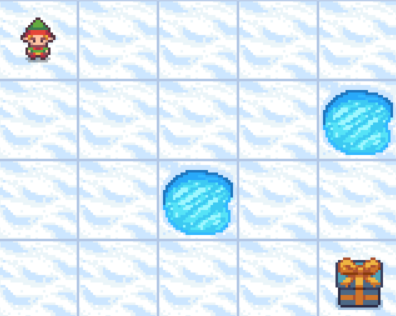

# Visualize 
(will be used later)

In [4]:
def print_array_as_map(env,array):
    desc = env.unwrapped.desc.astype(str)
    rows,cols=desc.shape
    print(np.reshape(array,(rows,cols)))
def return_policy_from_numbers_to_directions(policy):
    list_map=["W","S","E","N"]
    mapped_policy=[]
    for i in range(policy.shape[0]):
        mapped_policy.append(list_map[int(policy[i])])
    return np.array(mapped_policy)


In [5]:
def draw_policy_and_action_values(env, q_values, policy, use_greedy=True):
    desc = env.unwrapped.desc.astype(str)
    h, w = desc.shape
    plt.figure(figsize=(w, h))
    Q = np.array(q_values).reshape(h, w, -1)
    Pi = Q.argmax(axis=2) if use_greedy else np.array(policy).reshape(h, w)
    num_actions = Q.shape[2]
    vmax = Q.max()
    vmin = Q.min()
    value_map = Q.max(axis=2)
    plt.imshow(value_map, cmap='Blues', vmin=vmin, vmax=vmax)
    ax = plt.gca()
    ax.set_xticks(np.arange(w))
    ax.set_yticks(np.arange(h))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks(np.arange(-.5, w, 1), minor=True)
    ax.set_yticks(np.arange(-.5, h, 1), minor=True)
    ax.grid(which="minor", color="gray", linestyle='-', linewidth=1)
    plt.tick_params(which="minor", bottom=False, left=False)
    a2uv={0:(-0.3,0),1:(0,0.3),2:(0.3,0),3:(0,-0.3)}
    Qmin, Qmax = Q.min(), Q.max()
    for y in range(h):
        for x in range(w):
            state_desc = desc[y, x]
            if state_desc in ['H', 'G']:
                color = 'green' if state_desc == 'G' else 'red'
                plt.text(x, y, state_desc, color=color, ha='center', va='center', fontsize=16, fontweight='bold')
                continue
            for a in range(num_actions):
                dx, dy = a2uv[a]
                q = Q[y, x, a]
                norm_q = (q - Qmin) / (Qmax - Qmin + 1e-8)
                color = plt.cm.coolwarm(norm_q)
                arrow_dx, arrow_dy = dx * 0.8, dy * 0.8
                ax.add_patch(FancyArrowPatch(
                    (x, y), (x + arrow_dx, y + arrow_dy),
                    arrowstyle='->', color=color, lw=1.5, alpha=0.6,
                    mutation_scale=8))
                text_x, text_y = x + dx * 1.2, y + dy * 1.2
                ax.text(text_x, text_y, f"{q:.2f}",color='black', fontsize=4.5, ha='center', va='center')
            a = Pi[y, x]
            if a in a2uv:
                dx, dy = a2uv[a]
                ax.add_patch(FancyArrowPatch(
                    (x, y), (x + dx * 1.2, y + dy * 1.2),
                    arrowstyle='->', color='yellow', lw=2.5, alpha=0.9,
                    mutation_scale=20))
    plt.title("Q-values with Policy Overlay", fontsize=14)
    plt.show()

# this code in this code cell- the code for plotting (and only for plotting) 
# the policy with the action values was taken from the lecturer Idan template, and adjusted using ChatGPT  

## Q-learning
From the lecturer Idan's slides:
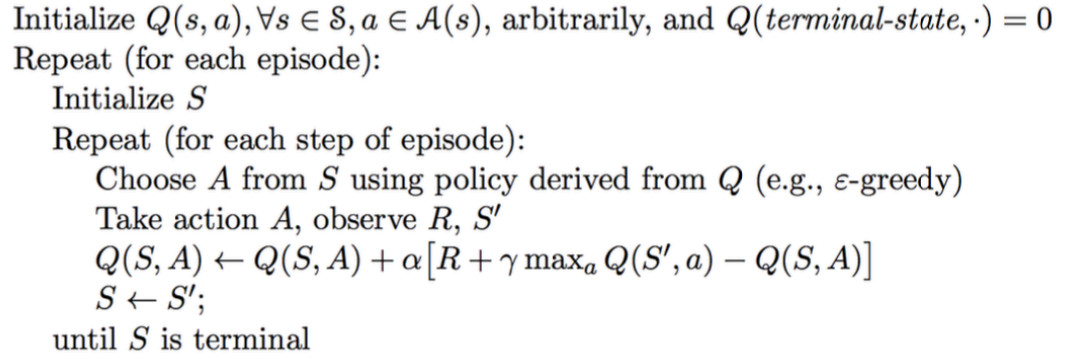

In [6]:
#FrozenLake gives reward if 1 of we win, and 0 for anything else. \
# I will want to adjust that to the requested in the assignment.
def return_reward_data(is_game_over,current_reward):
    if current_reward==1:
        return 1
    if is_game_over==False:
        return -0.08
    return -1
    

def play_and_get_state_is_game_over_and_reward(P,s,direction,probability=[0.8,0.1,0.1]):
    # P[state][action][empty brackets][_,newstate,reward,gameover]
    direction=(direction+np.random.choice([0, -1, 1], p=probability))%4 # slippering chance
    s_tilde=P[s][direction][0][1]
    is_game_over=P[s][direction][0][3]
    reward=P[s][direction][0][2] # our reward function is different, so we will change it
    return s_tilde,is_game_over,return_reward_data(is_game_over,reward)

# def get_gain(R,gamma):
#     G=np.zeros(len(R)+1) # G should have 1 more item in the array,
#     #but it will be 0 cause in the last state visited there is no reward
#     for i in range(-1,-len(R)-1,-1):
#         G[i-1]=R[i]+gamma*G[i]
#     return G
def get_gain(R,gamma):
    G=np.zeros(len(R)+1) # G should have 1 more item in the array,
    #but it will be 0 cause in the last state visited there is no reward
    for i in range(-1,-len(R)-1,-1):
        G[i-1]=R[i]+gamma*G[i]
    G[-1]=R[-1]
    return G
def new_state_by_state_and_direction(V,state,grid_size,direction): # no slippering
    V=np.reshape(V,grid_size)
    state_row=state//V.shape[1]
    state_col=state%V.shape[1]
    if direction==0:
        state_col-=1
        if state_col>=0:
            return state_row*V.shape[1]+state_col
        return state
    if direction==1:
        state_row+=1
        if state_row<V.shape[0]:
            return state_row*V.shape[1]+state_col
        return state
    if direction==2:
        state_col+=1
        if state_col<V.shape[1]:
            return state_row*V.shape[1]+state_col
        return state
    if direction==3:
        state_row-=1
        if state_row>=0:
            return state_row*V.shape[1]+state_col
        return state
def get_policy_from_values(V,states_visited,grid_size,policy):
    for state in states_visited: # can optimize by not repeating states already visited
        policy[state]=np.argmax((V[new_state_by_state_and_direction(V,state,grid_size,0)], #can be optimize, too many reshapes
                                V[new_state_by_state_and_direction(V,state,grid_size,1)],
                                V[new_state_by_state_and_direction(V,state,grid_size,2)],
                                V[new_state_by_state_and_direction(V,state,grid_size,3)]))
    return policy
def get_policy_from_action_values(Q,policy): # can be optimize, return states and action, using only states
    for state in Q: # can optimize by not repeating states already visited
        policy[state]=np.argmax(state)
    return policy

def get_action_epsilon_greedy(action,epsilon):
    is_exploring=np.random.choice([False,True],p=[1-epsilon,epsilon])
    if not(is_exploring):
        return action
    options=[i for i in range(4) if i != action]
    return np.random.choice(options)


In [39]:
def Q_learning_control(env,max_epoch):
    P=env.unwrapped.P
    desc = env.unwrapped.desc.astype(str).flatten()
    Q=np.zeros((desc.shape[0],4))
    policy=np.random.choice([0, 1, 2, 3], size=(desc.shape)) 
    # in holes and the goles the policy is meaningless
    alpha=0.01
    epsilon=1.00
    alpha_zero=0.3
    N=np.zeros(Q.shape)
    initial_epsilon=1
    beta=0.51
    policy_history=[]
    Q_history=[]
    iter_history=[]
    for i in range(1,max_epoch):
        is_current_game_over=False
        while True:
            state = np.random.randint(desc.shape[0])
            if desc[state] not in ["H", "G"]:
                break
        action=get_action_epsilon_greedy(policy[state],epsilon) #epsilon greedy
        while True:
            N[state,action]+=1
            alpha = alpha_zero / (N[state, action]**beta)
            if is_current_game_over:
                break
            new_state,is_current_game_over,reward=play_and_get_state_is_game_over_and_reward(P,state,action)
            new_action=get_action_epsilon_greedy(policy[new_state],epsilon) #epsilon greedy
            Q[state,action]+=alpha*(reward+gamma*np.max(Q[new_state])-Q[state,action])
            policy[state]=np.argmax(Q[state])
            state,action=new_state,new_action
        if i%1000==0 or i in [10,50,100,200,500,800]:
            print(f"this is the {i} iteration, epsilon is {epsilon}")
            iter_history.append(i)
            policy_history.append(np.copy(policy))
            Q_history.append(np.copy(Q))
        epsilon=initial_epsilon/(np.log((i+1))+1) 
    return Q,policy,iter_history,policy_history,Q_history
Q_learning_action_value,Q_learning_policy,iter_history,policy_history,Q_history=Q_learning_control(env,10000)

this is the 10 iteration, epsilon is 0.30279310656411385
this is the 50 iteration, epsilon is 0.2035821084092901
this is the 100 iteration, epsilon is 0.1784067150181842
this is the 200 iteration, epsilon is 0.15877256444891996
this is the 500 iteration, epsilon is 0.13860766743777758
this is the 800 iteration, epsilon is 0.13013019205636212
this is the 1000 iteration, epsilon is 0.12645813694537056
this is the 2000 iteration, epsilon is 0.1162668690528599
this is the 3000 iteration, epsilon is 0.11103255474403197
this is the 4000 iteration, epsilon is 0.10759572400874569
this is the 5000 iteration, epsilon is 0.10507299577588922
this is the 6000 iteration, epsilon is 0.10309794107839525
this is the 7000 iteration, epsilon is 0.10148507753821408
this is the 8000 iteration, epsilon is 0.10012819592492199
this is the 9000 iteration, epsilon is 0.09896110771311716


# Let's see the training proccess

this is the 10 iteration


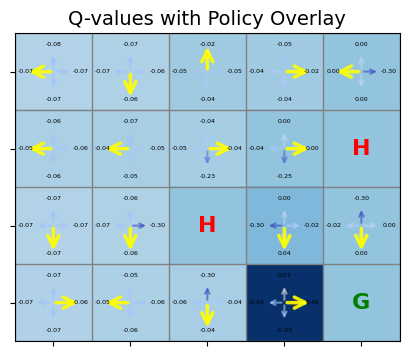

this is the 50 iteration


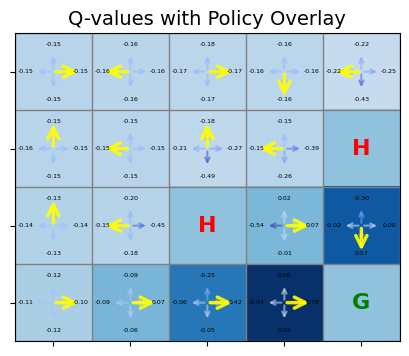

this is the 100 iteration


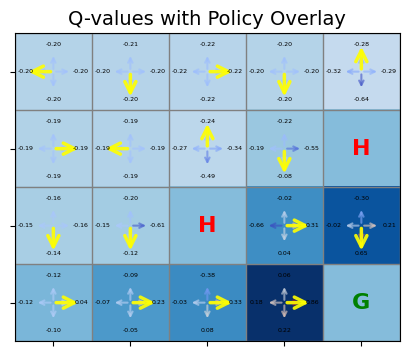

this is the 200 iteration


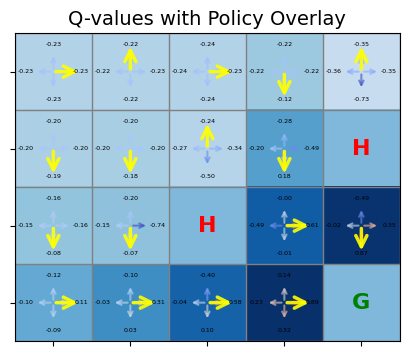

this is the 500 iteration


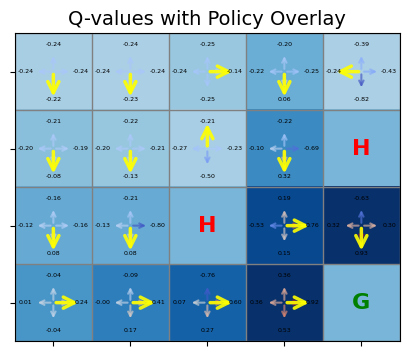

this is the 800 iteration


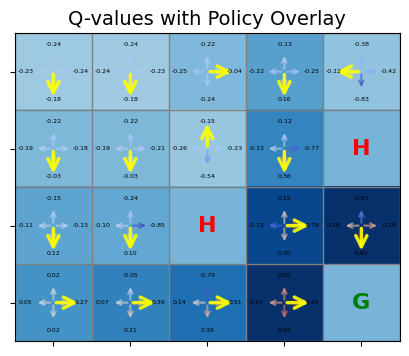

this is the 1000 iteration


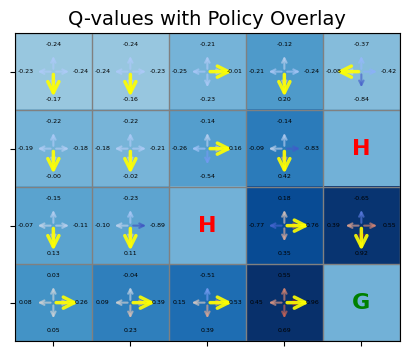

this is the 2000 iteration


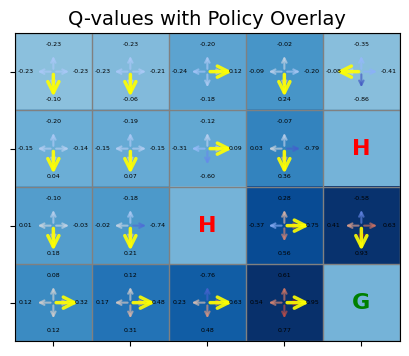

this is the 3000 iteration


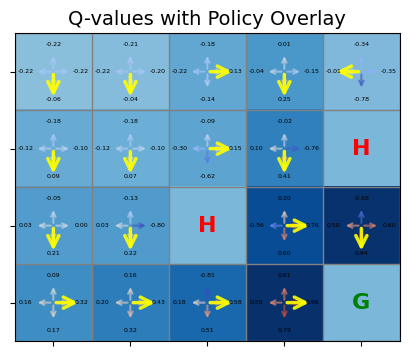

this is the 4000 iteration


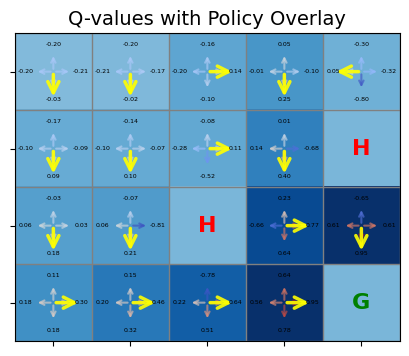

this is the 5000 iteration


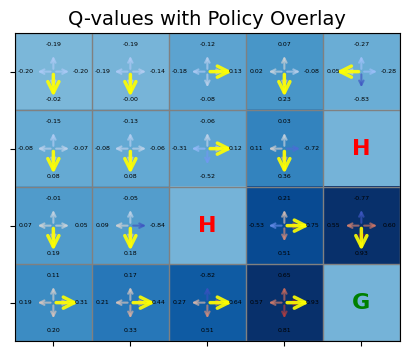

this is the 6000 iteration


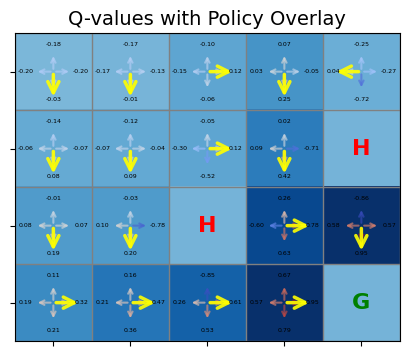

this is the 7000 iteration


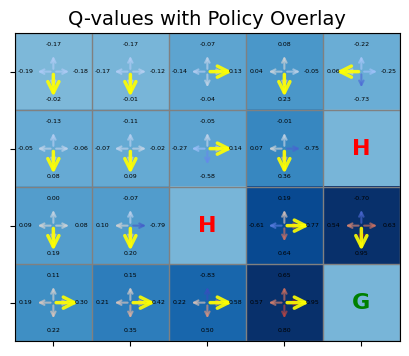

this is the 8000 iteration


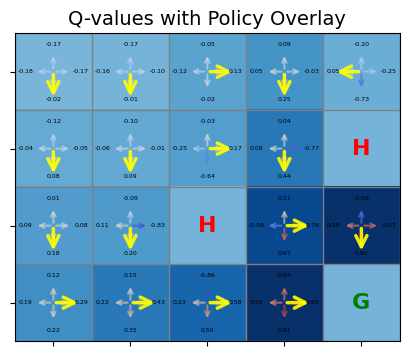

this is the 9000 iteration


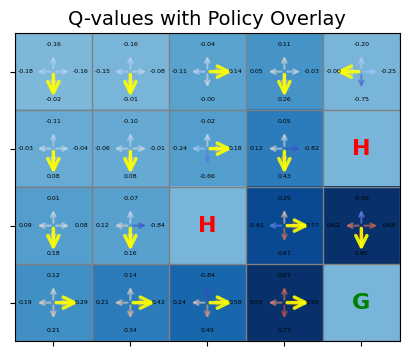

In [40]:
for i,action_values,current_policy in zip(iter_history,Q_history,policy_history):
    print(f"this is the {i} iteration")
    draw_policy_and_action_values(env,action_values,current_policy)

## Q-learning Final Results



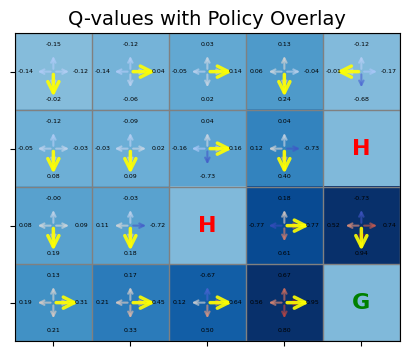

In [30]:
draw_policy_and_action_values(env,Q_learning_action_value,Q_learning_policy)

In [31]:
print(Q_learning_action_value)

[[-0.14001076 -0.01938547 -0.11936186 -0.14582302]
 [-0.14257262 -0.06303354  0.04464562 -0.12360484]
 [-0.05442032  0.02431066  0.13613514  0.02874071]
 [ 0.06016808  0.24177342 -0.03986211  0.12524962]
 [-0.00955944 -0.6819257  -0.17464343 -0.11588306]
 [-0.04708696  0.07988795 -0.02907206 -0.12460784]
 [-0.03216346  0.08939891  0.0201207  -0.08840587]
 [-0.1557535  -0.73490739  0.16454024  0.04238997]
 [ 0.11783724  0.39568332 -0.7313401   0.03751542]
 [ 0.          0.          0.          0.        ]
 [ 0.08214813  0.18803658  0.08638726 -0.00427082]
 [ 0.10627592  0.18292508 -0.72311898 -0.03211443]
 [ 0.          0.          0.          0.        ]
 [-0.76890822  0.61151694  0.77097862  0.17812774]
 [ 0.52361602  0.94464646  0.73809521 -0.72530077]
 [ 0.19363283  0.21111426  0.31027394  0.13435872]
 [ 0.21167417  0.32712209  0.45032291  0.16578331]
 [ 0.12325464  0.50138096  0.64100574 -0.67214979]
 [ 0.55992635  0.80306126  0.949772    0.6660078 ]
 [ 0.          0.          0.  

We could see that the action values converged in about 10,000 epochs.<br>
This alogrothm got the optimal policy, in about 10000 epochs, but the action values didn't converge.<br>
With time it command, the time for 10000 epochs ( the amount that gave convergence), we got:<br>
3.32 s ± 1.68 s per loop (mean ± std. dev. of 10 runs, 10 loops each)

In [ ]:
%timeit -n 10 -r 10 Q_learning_control(env, 10000)
# 3.32 s ± 1.68 s per loop (mean ± std. dev. of 10 runs, 10 loops each)

this is the 10 iteration, epsilon is 0.30279310656411385
this is the 50 iteration, epsilon is 0.2035821084092901
this is the 100 iteration, epsilon is 0.1784067150181842
this is the 200 iteration, epsilon is 0.15877256444891996
this is the 500 iteration, epsilon is 0.13860766743777758
this is the 800 iteration, epsilon is 0.13013019205636212
this is the 1000 iteration, epsilon is 0.12645813694537056
this is the 2000 iteration, epsilon is 0.1162668690528599
this is the 3000 iteration, epsilon is 0.11103255474403197
this is the 4000 iteration, epsilon is 0.10759572400874569
this is the 5000 iteration, epsilon is 0.10507299577588922
this is the 6000 iteration, epsilon is 0.10309794107839525
this is the 7000 iteration, epsilon is 0.10148507753821408
this is the 8000 iteration, epsilon is 0.10012819592492199
this is the 9000 iteration, epsilon is 0.09896110771311716
this is the 10 iteration, epsilon is 0.30279310656411385
this is the 50 iteration, epsilon is 0.2035821084092901
this is the 1